In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from datetime import datetime
import re 
from enum import IntEnum
#import seaborn as sns
import os
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from itertools import groupby
from operator import itemgetter

In [2]:
# # experiment computer has locale set to german -_-
import locale
import contextlib
@contextlib.contextmanager
def setlocale(*args, **kw):
    saved = locale.setlocale(locale.LC_ALL)
    yield locale.setlocale(*args, **kw)
    locale.setlocale(locale.LC_ALL, saved)

PIX_PER_MM = 38.773681409813456
CAM_WIDTH = 2048
CAM_HEIGHT = 2048

def parse_filename(filename: str, loc: str = 'de_DE.utf8') -> Tuple:

    regexp = re.compile(r"""
        (?P<fish_id>\d+)_
        (?P<dpf>\d+)dpf_
        (?P<datetime>\w+).csv
        """, re.VERBOSE)

    match = regexp.fullmatch(filename)
    if match is None:
        raise RuntimeError(f'Wrong filename format, {filename}')
    
    fish_id = int(match.group('fish_id'))
    dpf = int(match.group('dpf'))
    
    with setlocale(locale.LC_ALL, loc):
        date = datetime.strptime(match.group('datetime'),'%a_%d_%b_%Y_%Hh%Mmin%Ssec')
    
    return (fish_id, dpf, date)

def get_relative_time(data):
    return data['t_local'] - data['t_local'].iloc[0]

def get_relative_index(data):
    return data.index - data.index[0]

def get_heading_angle(data):
    angle = np.arctan2(data['pc1_y'],data['pc1_x'])
    notna = ~np.isnan(angle)
    angle_unwrapped = np.zeros_like(angle) * np.nan
    angle_unwrapped[notna] = np.unwrap(angle[notna]) # TODO this is probably a bit wrong
    return angle, angle_unwrapped

def get_cumulative_distance(data):
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    frame_distances = np.sqrt(x_diff**2 + y_diff**2) * 1/PIX_PER_MM
    return frame_distances.cumsum()  # This gives total distance traveled over time

def get_displacement(data):
    x_displacement = (data['centroid_x'] - data['centroid_x'].iloc[0]) * 1/PIX_PER_MM
    y_displacement = (data['centroid_y'] - data['centroid_y'].iloc[0]) * 1/PIX_PER_MM
    return np.sqrt(x_displacement**2 + y_displacement**2)

class StimType(IntEnum):
    DARK = 0
    phototaxis = 1
    PHOTOTAXIS = 2
    OMR = 3
    OKR = 4
    LOOMING = 5

def get_cumulative_speed(data):
    # For frame-to-frame calculations, each time step is 1 unit
    x_diff = data['centroid_x'].diff()
    y_diff = data['centroid_y'].diff()
    frame_distances = np.sqrt(x_diff**2 + y_diff**2) * 1/PIX_PER_MM
    speed = frame_distances/ get_relative_time(data).diff()  # distance per frame
    return speed


In [18]:
def smooth_data(speed_data, method='gaussian', **kwargs):
    # Convert to pandas Series if not already
    data = pd.Series(speed_data)
    
    if method == 'gaussian':
        # Default parameters
        sigma = kwargs.get('sigma', 2)
        
        # Create a copy to avoid modifying the original
        smoothed = data.copy()
    
        # Apply Gaussian filter to data and mask
        smoothed = gaussian_filter1d(data.values, sigma=sigma)
        
    elif method == 'moving_avg':
        # Default parameters
        window = kwargs.get('window', 15)
        min_periods = kwargs.get('min_periods', 1)
        
        # Apply rolling window average
        smoothed = data.rolling(
            window=window, 
            center=True, 
            min_periods=min_periods
        ).mean()
        
    elif method == 'ewm':
        # Default parameters
        span = kwargs.get('span', 10)
        min_periods = kwargs.get('min_periods', 1)
        
        # Apply exponentially weighted moving average
        smoothed = data.ewm(
            span=span, 
            min_periods=min_periods
        ).mean()
    
    else:
        raise ValueError(f"Unknown smoothing method: {method}")
        
    return smoothed

def detect_fish_bouts_2(data, fish_id=None, method='gaussian', **kwargs):
    """
    Process fish movement data to detect swimming bouts
    
    Parameters:
    - data: DataFrame containing fish movement data
    - fish_id: Optional ID for the fish (for plot titles)
    - method: Smoothing method to use ('gaussian', 'moving_avg', 'ewm')
    - kwargs: Additional parameters for the smoothing method
    
    Returns:
    - Dictionary containing processed data and bout information
    """
    # Make a copy to avoid modifying the original data
    df = data.reset_index(drop=True).copy()
    
    smoothed_speed = smooth_data(df['speed'], method=method, **kwargs)
    df['smoothed_speed'] = smoothed_speed
    
    # Calculate threshold for bout detection
    mean_speed = np.mean(smoothed_speed)
    std_speed = np.std(smoothed_speed)
    threshold = mean_speed + 2 * std_speed
    
    # Find peaks in the smoothed data (potential bout centers)
    peaks, peak_properties = find_peaks(
        smoothed_speed, 
        height=threshold,
        distance=10,  # Minimum samples between peaks
        prominence=0.5 * std_speed  # Minimum prominence to be considered a peak
    )
    
    # Find regions where speed exceeds threshold (bout regions)
    bout_indices = np.where(smoothed_speed > threshold)[0]
    
    # Group consecutive indices to identify complete bouts
    bout_groups = []
    for k, g in groupby(enumerate(bout_indices), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        if len(group) > 3:  # Minimum number of frames to be considered a bout
            bout_groups.append((group[0], group[-1]))
    
    # Create a DataFrame to store bout information
    bout_info = []
    for i, (start_idx, end_idx) in enumerate(bout_groups):
        # Find the peak within this bout
        bout_peaks = [p for p in peaks if start_idx <= p <= end_idx]
        
        if bout_peaks:
            peak_idx = bout_peaks[np.argmax(smoothed_speed[bout_peaks])]
            peak_speed = smoothed_speed[peak_idx]
            
            # Calculate bout properties
            bout_info.append({
                'bout_id': i+1,
                'start_idx': start_idx,
                'peak_idx': peak_idx,
                'end_idx': end_idx,
                'start_time': df['relative_time'].iloc[start_idx],
                'peak_time': df['relative_time'].iloc[peak_idx],
                'end_time': df['relative_time'].iloc[end_idx],
                'duration': df['relative_time'].iloc[end_idx] - df['relative_time'].iloc[start_idx],
                'peak_speed': peak_speed,
                'mean_speed': np.mean(smoothed_speed[start_idx:end_idx+1])
            })
    
    bout_df = pd.DataFrame(bout_info)
    
    return {
        'processed_data': df,
        'smoothed_speed': smoothed_speed,
        'threshold': threshold,
        'peaks': peaks,
        'bout_groups': bout_groups,
        'bout_df': bout_df,
        'fish_id': fish_id
    }

def plot_bout_detection(results):
    """
    Create plots to visualize the bout detection process
    
    Parameters:
    - results: Dictionary returned by detect_fish_bouts function
    """
    df = results['processed_data']
    fish_id = results['fish_id']
    smoothed_speed = results['smoothed_speed']
    threshold = results['threshold']
    peaks = results['peaks']
    bout_groups = results['bout_groups']
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot 1: Original vs Smoothed Speed
    ax1.plot(df['relative_time'], df['speed'], 'b-', alpha=0.5, label='Raw Speed')
    ax1.plot(df['relative_time'], smoothed_speed, 'g-', linewidth=2, label='Smoothed Speed')
    ax1.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
    ax1.set_ylabel('Speed (mm/sec)')
    ax1.set_title(f'Original vs Smoothed Speed for Fish ID: {fish_id}')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot 2: Detected Bouts
    ax2.plot(df['relative_time'], smoothed_speed, 'g-', label='Smoothed Speed')
    ax2.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
    
    # Highlight bout regions
    for start_idx, end_idx in bout_groups:
        start_time = df['relative_time'].iloc[start_idx]
        end_time = df['relative_time'].iloc[end_idx]
        ax2.axvspan(start_time, end_time, alpha=0.2, color='orange')
    
    # Mark peak points
    peak_times = df['relative_time'].iloc[peaks]
    peak_speeds = smoothed_speed[peaks]
    ax2.scatter(peak_times, peak_speeds, color='red', s=50, zorder=5, label='Bout Peaks')
    
    ax2.set_xlabel('Relative Time')
    ax2.set_ylabel('Speed (mm/sec)')
    ax2.set_title(f'Detected Swimming Bouts for Fish ID: {fish_id}')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_bout_statistics(results):
    """
    Print statistics about the detected bouts
    
    Parameters:
    - results: Dictionary returned by detect_fish_bouts function
    """
    bout_df = results['bout_df']
    fish_id = results['fish_id']
    
    print(f"\nBout Statistics for Fish ID: {fish_id}")
    print(f"Total number of bouts detected: {len(bout_df)}")
    
    if len(bout_df) > 0:
        print(f"Average bout duration: {bout_df['duration'].mean():.2f} time units")
        print(f"Average bout peak speed: {bout_df['peak_speed'].mean():.2f} mm/sec")
        print(f"Average bout mean speed: {bout_df['mean_speed'].mean():.2f} mm/sec")
        print("\nTop 5 bouts by peak speed:")
        print(bout_df.sort_values('peak_speed', ascending=False).head(5)[['bout_id', 'start_time', 'duration', 'peak_speed']])

In [4]:
#read the files, make separate dataframes by grouping the StimType, and add the parsed columns to it
#use the get_relative_time , get_relative_index, get_heading_angle, get_distance functions
#Plot the centroids
#plot the heading_angle
#calculate the speed


DATA_FOLDER = r".\Modelling_data\Cichlids"

DATAFILES = [
    "08_09dpf_Di_27_Aug_2024_14h50min47sec.csv", 
    "09_09dpf_Di_27_Aug_2024_16h03min14sec.csv"
]


# Initialize dictionaries for specific stimulus types
target_stims = [StimType.DARK, StimType.phototaxis, StimType.PHOTOTAXIS]
stim_dataframes = {stim: pd.DataFrame() for stim in target_stims}

for file in DATAFILES:
   fish_id, dpf, date = parse_filename(file)
   
   # Read and preprocess data
   data = pd.read_csv(os.path.join(DATA_FOLDER, file))
   data_filtered = data.groupby('image_index').first()
   data_filtered = data_filtered[1:]
   data_filtered['stim_id'] = data_filtered['stim_id'].astype(int)
   
   # Add parsed metadata to each row
   data_filtered['fish_id'] = fish_id
   data_filtered['dpf'] = dpf
   data_filtered['date'] = date
   
   # Group by specific stimulus types and concatenate
   for stim in target_stims:
       stim_data = data_filtered[data_filtered['stim_id'] == stim.value]
       stim_dataframes[stim] = pd.concat([stim_dataframes[stim], stim_data])

# Optional: Save each stimulus type DataFrame
for stim, df in stim_dataframes.items():
   if not df.empty:
       df.to_csv(f'{stim.name.lower()}_data.csv', index=False)


NaN values in bright_df before any processing:
 t_display                             0
t_local                               0
latency                               0
centroid_x                            0
centroid_y                            0
                                     ..
looming_expansion_time_sec            0
looming_expansion_speed_mm_per_sec    0
fish_id                               0
dpf                                   0
date                                  0
Length: 110, dtype: int64
NaN values in group for fish_id 8:
 t_display          0
t_local            0
latency            0
centroid_x         0
centroid_y         0
                  ..
relative_index     0
distance           0
angle              0
unwrapped_angle    0
speed              0
Length: 116, dtype: int64
Rows with NaN values in group for fish_id 8:
 Empty DataFrame
Columns: [t_display, t_local, latency, centroid_x, centroid_y, pc1_x, pc1_y, pc2_x, pc2_y, left_eye_x, left_eye_y, left_eye_angle, 

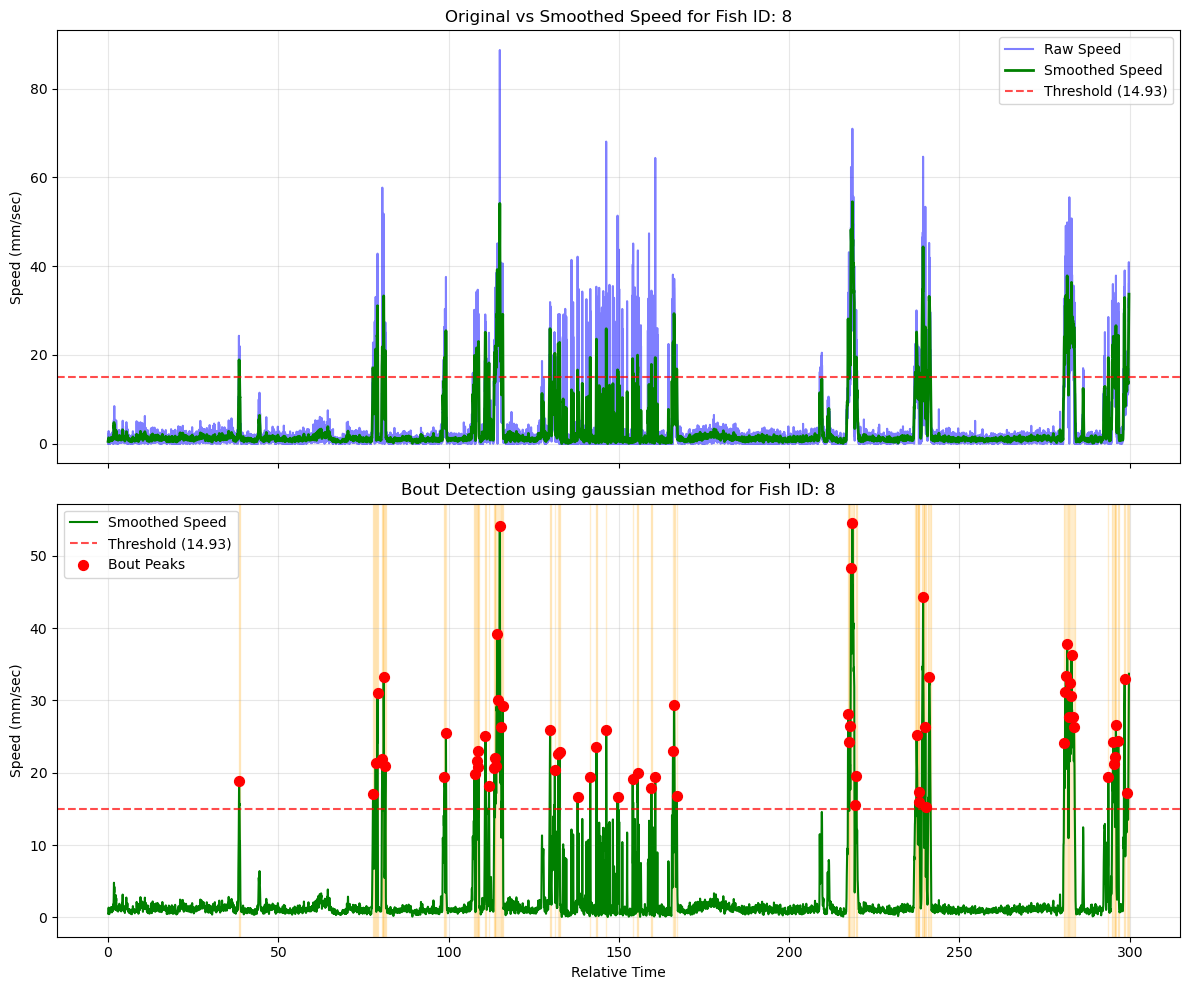

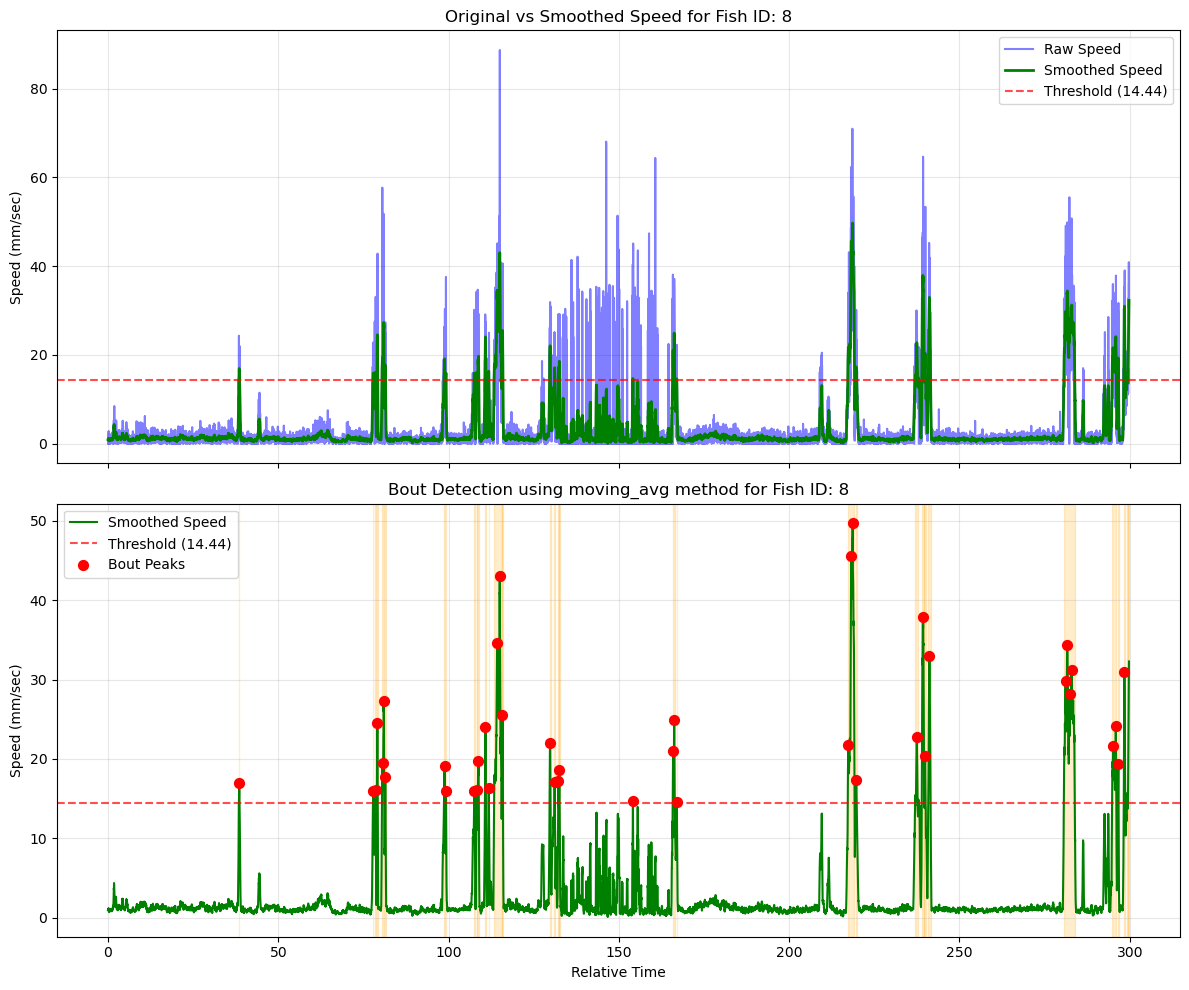

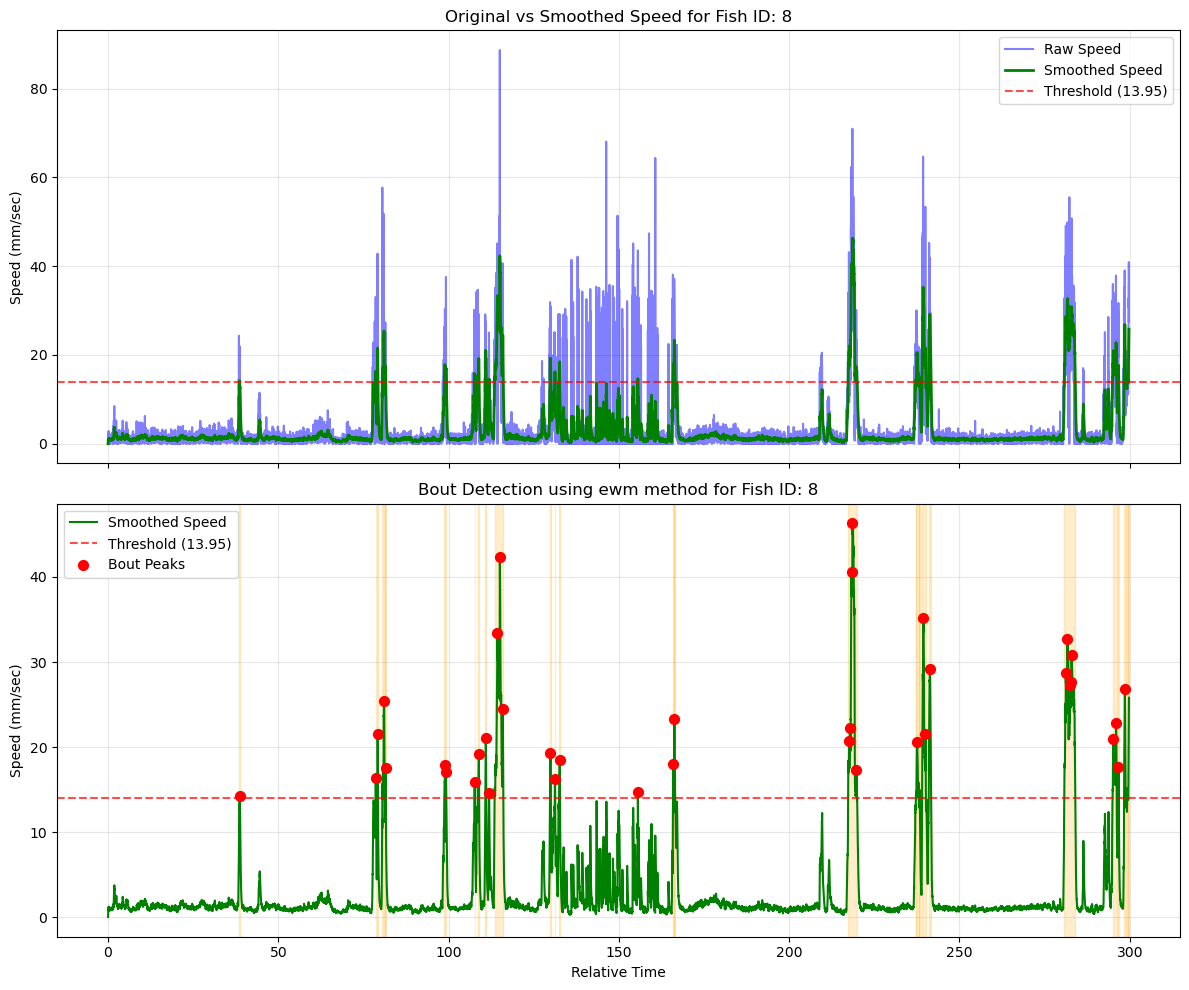

Bout statistics for method gaussian:

Bout Statistics for Fish ID: 8
Total number of bouts detected: 48
Average bout duration: 0.33 time units
Average bout peak speed: 25.24 mm/sec
Average bout mean speed: 20.57 mm/sec

Top 5 bouts by peak speed:
    bout_id  start_time  duration  peak_speed
32       33  217.650694  1.502189   54.491657
16       17  113.638822  1.814752   54.116097
37       40  238.918189  0.637982   44.338190
40       43  280.676268  1.297175   37.807058
41       44  282.052893  1.772395   36.341691
Bout statistics for method moving_avg:

Bout Statistics for Fish ID: 8
Total number of bouts detected: 31
Average bout duration: 0.52 time units
Average bout peak speed: 23.18 mm/sec
Average bout mean speed: 18.99 mm/sec

Top 5 bouts by peak speed:
    bout_id  start_time  duration  peak_speed
21       22  217.187949  1.981389   49.695838
13       14  113.371554  2.165256   43.021871
24       25  238.918189  0.734087   37.905764
27       28  280.638742  3.216069   34.41770

C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_5016\3722672853.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


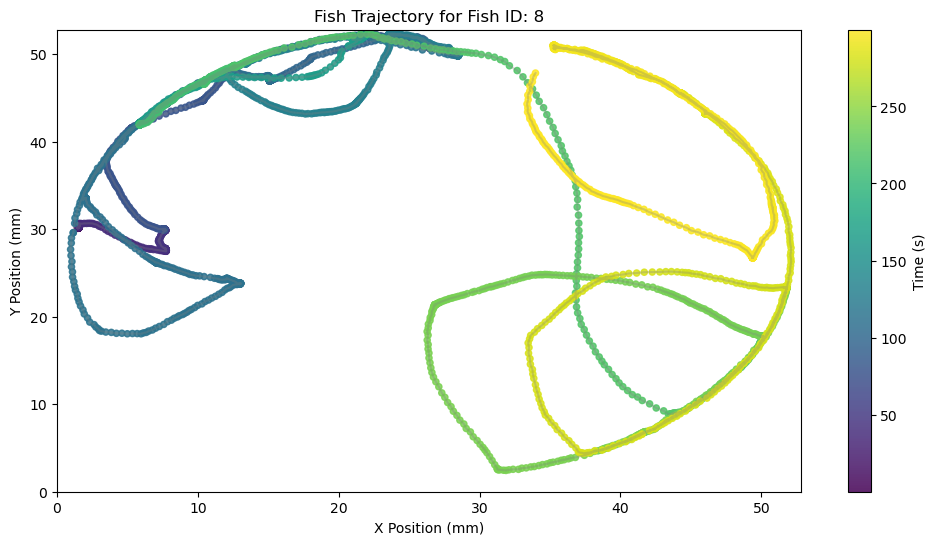

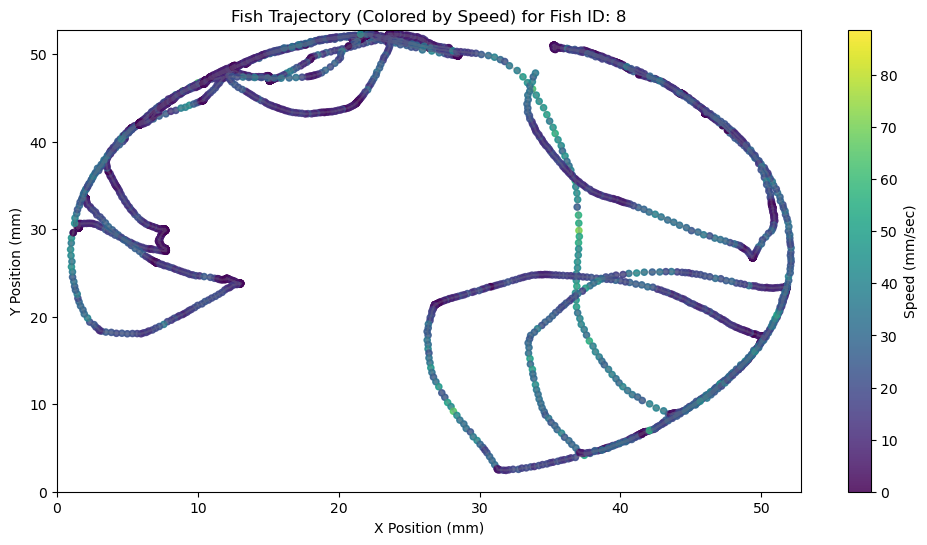

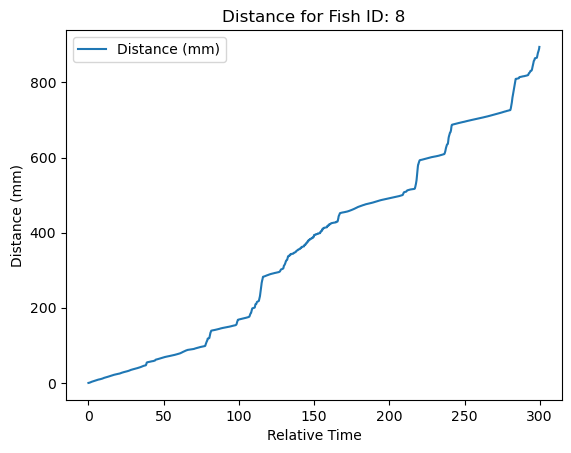

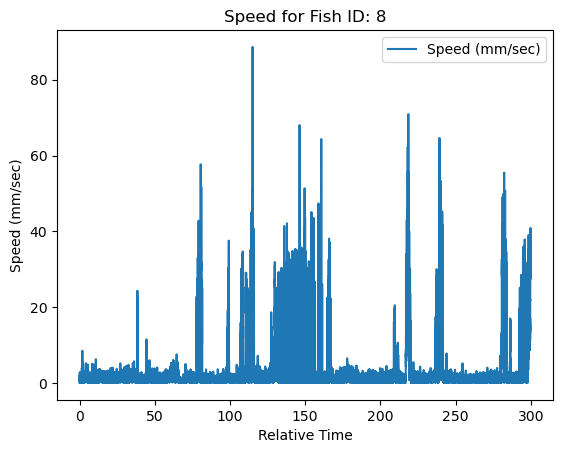

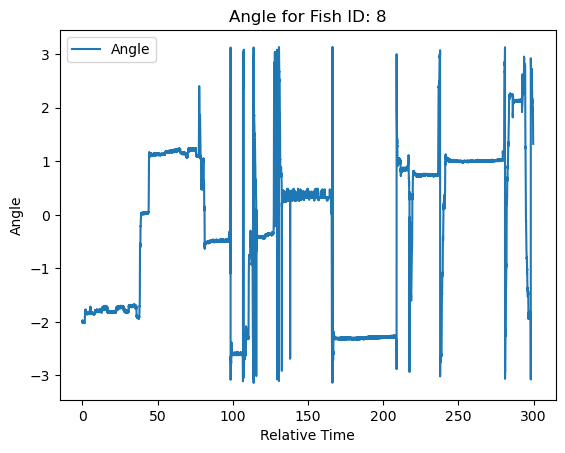

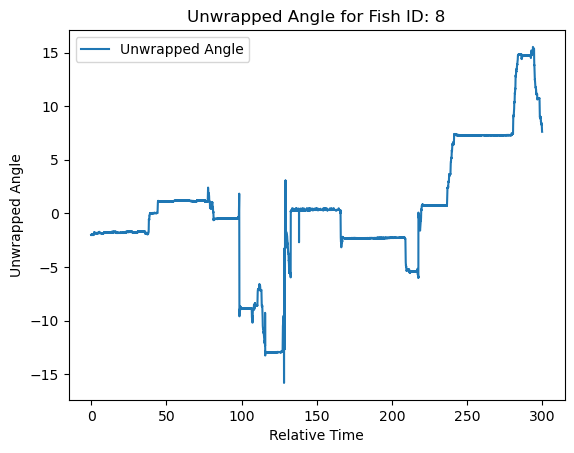

NaN values in group for fish_id 9:
 t_display          0
t_local            0
latency            0
centroid_x         0
centroid_y         0
                  ..
relative_index     0
distance           0
angle              0
unwrapped_angle    0
speed              0
Length: 116, dtype: int64
Rows with NaN values in group for fish_id 9:
 Empty DataFrame
Columns: [t_display, t_local, latency, centroid_x, centroid_y, pc1_x, pc1_y, pc2_x, pc2_y, left_eye_x, left_eye_y, left_eye_angle, right_eye_x, right_eye_y, right_eye_angle, tail_point_000_x, tail_point_001_x, tail_point_002_x, tail_point_003_x, tail_point_004_x, tail_point_005_x, tail_point_006_x, tail_point_007_x, tail_point_008_x, tail_point_009_x, tail_point_010_x, tail_point_011_x, tail_point_012_x, tail_point_013_x, tail_point_014_x, tail_point_015_x, tail_point_016_x, tail_point_017_x, tail_point_018_x, tail_point_019_x, tail_point_020_x, tail_point_021_x, tail_point_022_x, tail_point_023_x, tail_point_024_x, tail_point_025_x, tai

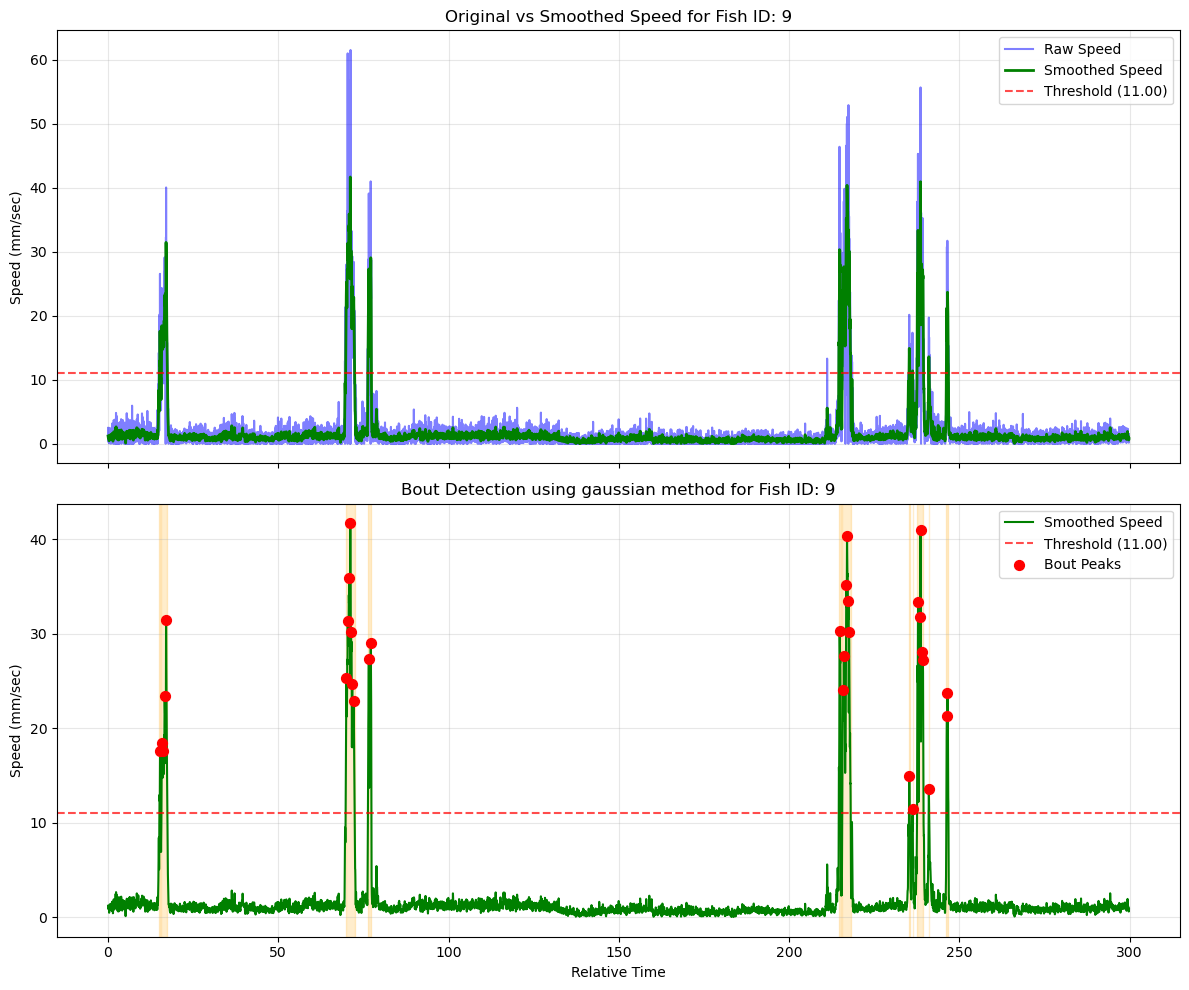

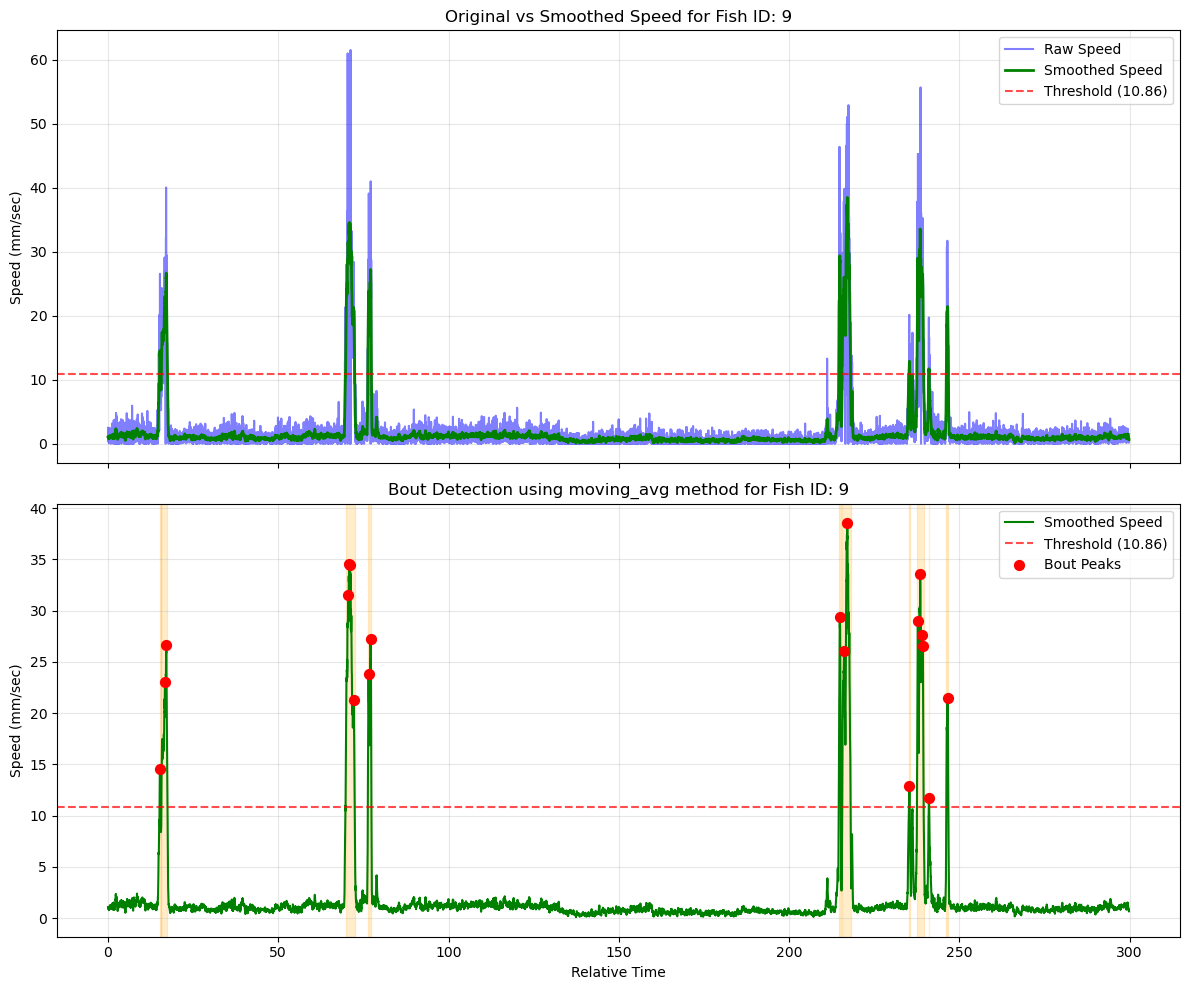

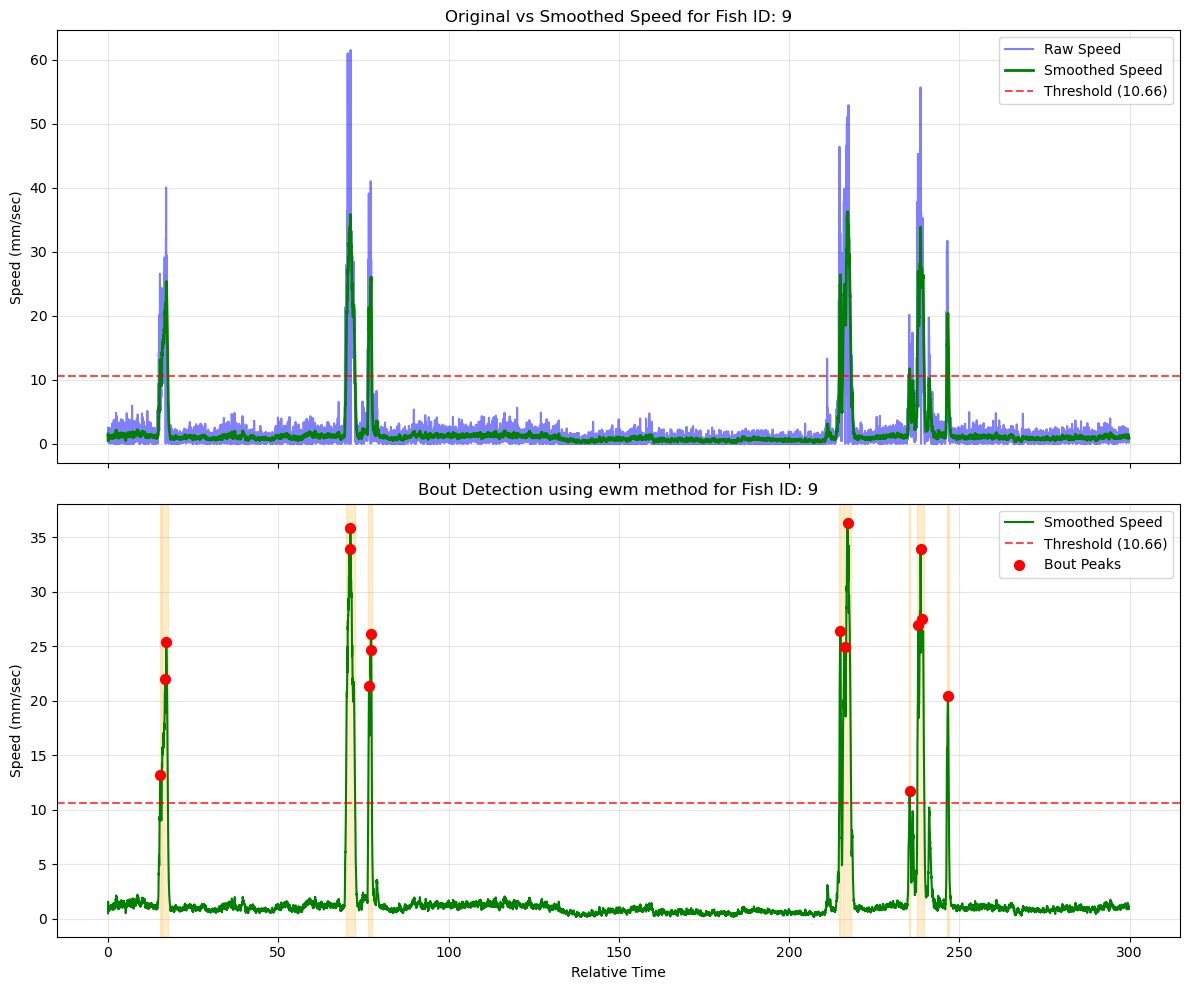

Bout statistics for method gaussian:

Bout Statistics for Fish ID: 9
Total number of bouts detected: 11
Average bout duration: 1.05 time units
Average bout peak speed: 26.83 mm/sec
Average bout mean speed: 18.99 mm/sec

Top 5 bouts by peak speed:
   bout_id  start_time  duration  peak_speed
2        3   69.778441  2.648348   41.702662
8        9  237.561984  1.881651   40.960887
5        6  215.590426  2.469200   40.402247
1        2   15.707721  1.718355   31.475868
4        5  214.576578  0.550707   30.339090
Bout statistics for method moving_avg:

Bout Statistics for Fish ID: 9
Total number of bouts detected: 10
Average bout duration: 1.16 time units
Average bout peak speed: 25.06 mm/sec
Average bout mean speed: 19.26 mm/sec

Top 5 bouts by peak speed:
   bout_id  start_time  duration  peak_speed
5        6  215.611071  2.418916   38.508377
2        3   69.761719  2.665070   34.567204
7        8  237.512295  1.964427   33.577101
4        5  214.593249  0.550771   29.386241
3        

C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_5016\3722672853.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


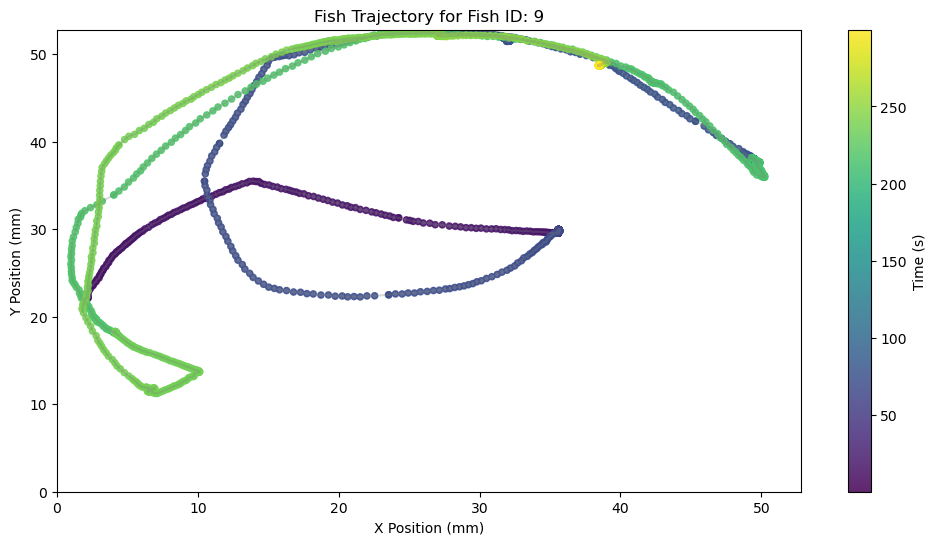

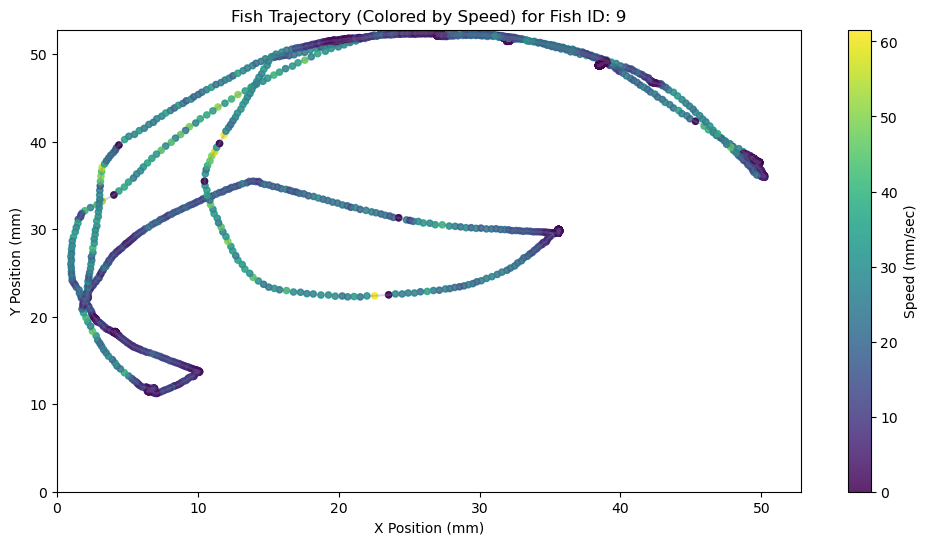

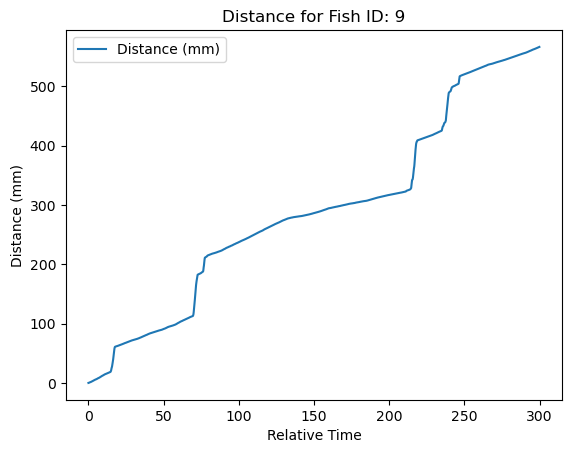

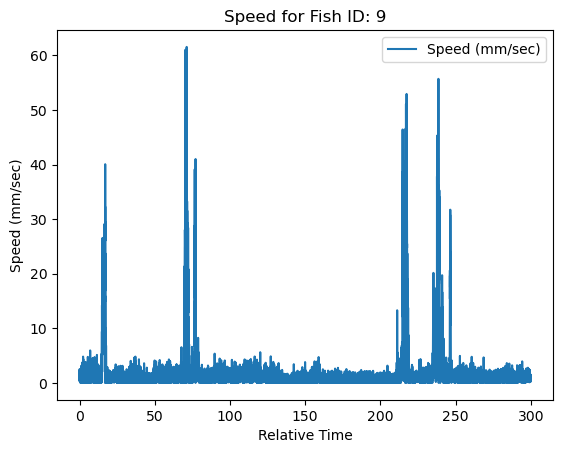

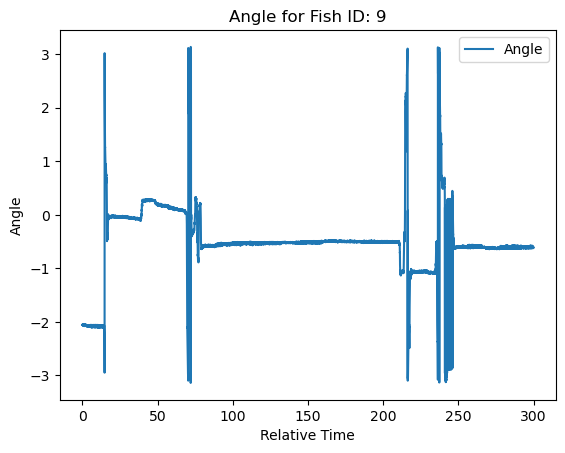

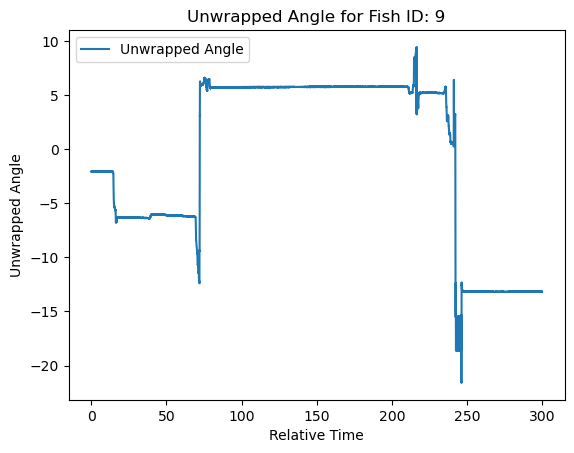

In [22]:
# Load the data
bright_df = pd.read_csv(r'.\bright_data.csv')
# Check for NaN values in the original DataFrame
print("NaN values in bright_df before any processing:\n", bright_df.isna().sum())

grouped_df = bright_df.groupby('fish_id')
for fish_id, group in grouped_df:
            group['relative_time'] = get_relative_time(group)
            group['relative_index'] = get_relative_index(group)
            group['distance'] = get_cumulative_distance(group)
            group['angle'], group['unwrapped_angle'] = get_heading_angle(group)
            group['speed'] = get_cumulative_speed(group)
            # Discard the first point in the trajectory
            group = group.dropna(subset=['speed', 'distance'])
            # Check for NaN values after preprocessing
            print(f"NaN values in group for fish_id {fish_id}:\n", group.isna().sum())
            nan_rows = group[group.isna().any(axis=1)]
            print(f"Rows with NaN values in group for fish_id {fish_id}:\n", nan_rows)

            nan_speed_rows = group[group['speed'].isna()]
            print(f"Rows with NaN values in speed for fish_id {fish_id} after get_cumulative_speed:\n", nan_speed_rows)
            print(f"NaN values in speed for fish_id {fish_id} after get_cumulative_speed:\n", group['speed'].isna().sum())
            #window_size = 10  # Adjust the window size as needed
            #std_dev = 5  # Standard deviation for the Gaussian window
            #group['smoothed_speed'] = group['speed'].rolling(window=window_size, min_periods=1, center=True).mean()

           # High-pass filter: subtract the smoothed signal from the original signal
            #group['high_pass_speed'] = group['speed'] - group['smoothed_speed']

            # First pass with a wider window
            #smoothed_speed = savgol_filter(group['speed'], window_size=25, poly_order=3)
            # Second pass with another filter
            #smoothed_speed = gaussian_filter1d(smoothed_speed, sigma=2)
            # Step 1: Smooth the speed data
            #smoothed_speed = smooth_speed(group['speed'], sigma=3)

            # Step 2: Find peaks in the smoothed data
            #peaks, _ = find_peaks(smoothed_speed, height=0.1, distance=10)  # Adjust height and distance parameters
            group = group.reset_index(drop=True)
            methods = ['gaussian', 'moving_avg', 'ewm']
            results_dict = {}

            for method in methods:
                if method == 'gaussian':
                    results = detect_fish_bouts_2(group, fish_id, method=method, sigma=2)
                elif method == 'moving_avg':
                    results = detect_fish_bouts_2(group, fish_id, method=method, window=15)
                elif method == 'ewm':
                    results = detect_fish_bouts_2(group, fish_id, method=method, span=20)
                
                results_dict[method] = results

                # Plot the results
                fig = plot_bout_detection(results)
                plt.title(f'Bout Detection using {method} method for Fish ID: {fish_id}')
                plt.show()

            # Compare bout statistics
            for method, results in results_dict.items():
                print(f"Bout statistics for method {method}:")
                print_bout_statistics(results)


            # Plotting
            custom_cmap = plt.cm.get_cmap('viridis')
            
            # Trajectory plot
            plt.figure(figsize=(12, 6))
            plt.scatter(
                group['centroid_x'] / PIX_PER_MM, 
                group['centroid_y'] / PIX_PER_MM, 
                c=group['relative_time'], 
                cmap=custom_cmap, 
                s=20, 
                alpha=0.85
            )
            plt.colorbar(label='Time (s)')
            plt.title(f'Fish Trajectory for Fish ID: {fish_id}')
            plt.xlabel('X Position (mm)')
            plt.ylabel('Y Position (mm)')
            plt.plot(
                group['centroid_x'] / PIX_PER_MM, 
                group['centroid_y'] / PIX_PER_MM, 
                color='gray', 
                linewidth=1.5, 
                alpha=0.3
            )
            plt.xlim(0, CAM_WIDTH / PIX_PER_MM)
            plt.ylim(0, CAM_HEIGHT / PIX_PER_MM)
            plt.show()
            
            # Trajectory plot colored by cumulative speed
            plt.figure(figsize=(12, 6))
            plt.scatter(
                group['centroid_x'] / PIX_PER_MM, 
                group['centroid_y'] / PIX_PER_MM, 
                c=group['speed'], 
                cmap=custom_cmap, 
                s=20, 
                alpha=0.85
            )
            plt.colorbar(label='Speed (mm/sec)')
            plt.title(f'Fish Trajectory (Colored by Speed) for Fish ID: {fish_id}')
            plt.xlabel('X Position (mm)')
            plt.ylabel('Y Position (mm)')
            plt.plot(
                group['centroid_x'] / PIX_PER_MM, 
                group['centroid_y'] / PIX_PER_MM, 
                color='gray', 
                linewidth=1.5, 
                alpha=0.3
            )
            plt.xlim(0, CAM_WIDTH / PIX_PER_MM)
            plt.ylim(0, CAM_HEIGHT / PIX_PER_MM)
            plt.show()
            

            # Distance plot
            plt.figure()
            plt.plot(group['relative_time'], group['distance'], label='Distance (mm)')
            plt.title(f'Distance for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Distance (mm)')
            plt.legend()
            plt.show()
            
            # Speed plot
            plt.figure()
            plt.plot(group['relative_time'], group['speed'], label='Speed (mm/sec)')
            plt.title(f'Speed for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Speed (mm/sec)')
            plt.legend()
            plt.show()

            #Smoothed speed plot
            # plt.figure()
            # plt.plot(group['relative_time'], group['smoothed_speed'], label='Smoothed Speed (mm/sec)')
            # plt.title(f'Smoothed Speed for Fish ID: {fish_id}')
            # plt.xlabel('Relative Time')
            # plt.ylabel('Smoothed Speed (mm/sec)')
            # plt.legend()
            # plt.show()

            # # Step 3: Plot original and smoothed data with detected peaks
            # plt.figure(figsize=(10, 6))
            # #plt.plot(group['relative_time'], group['speed'], 'b-', alpha=0.5, label='Raw Speed')
            # plt.plot(group['relative_time'], smoothed_speed, 'g-', label='Smoothed Speed')
            # #plt.plot(group['relative_time'].iloc[peaks], smoothed_speed[peaks], 'ro', label='Detected Bouts')
            # plt.title(f'Smoothed Speed Fish ID: {fish_id}')
            # plt.xlabel('Relative Time')
            # plt.ylabel('Speed (mm/sec)')
            # plt.legend()
            # plt.show()
            
            # Angle plot
            plt.figure()
            plt.plot(group['relative_time'], group['angle'], label='Angle')
            plt.title(f'Angle for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Angle')
            plt.legend()
            plt.show()
            
            # Unwrapped angle plot
            plt.figure()
            plt.plot(group['relative_time'], group['unwrapped_angle'], label='Unwrapped Angle')
            plt.title(f'Unwrapped Angle for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Unwrapped Angle')
            plt.legend()
            plt.show()

C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_11436\4222743830.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


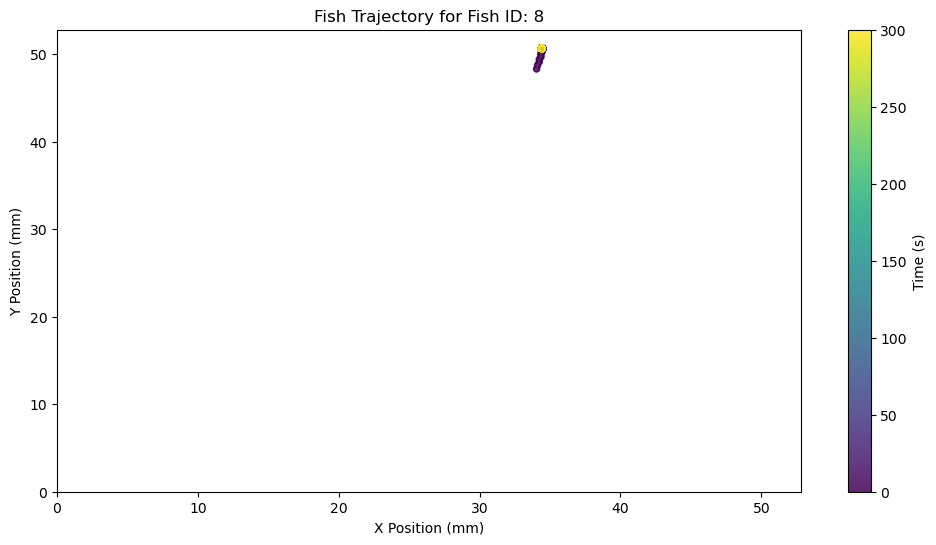

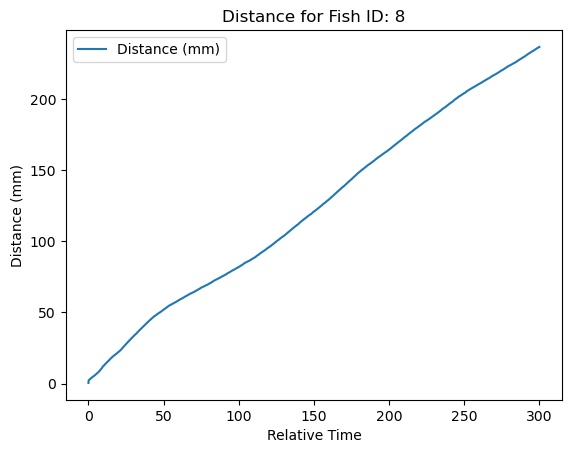

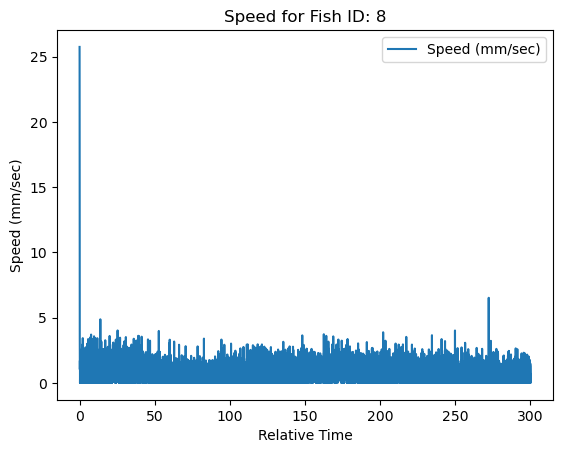

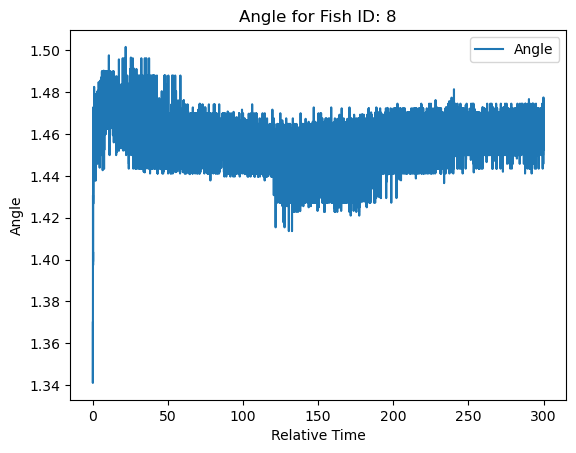

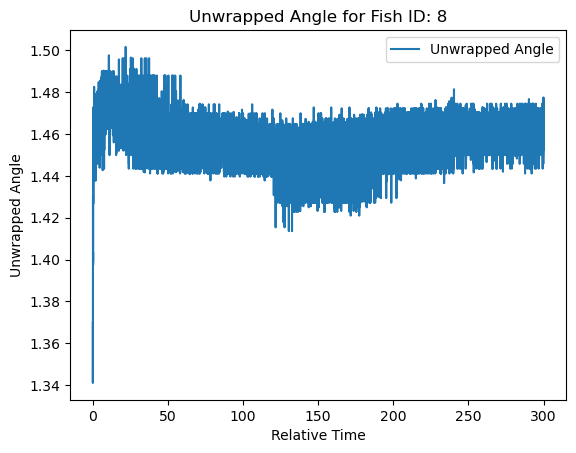

C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_11436\4222743830.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


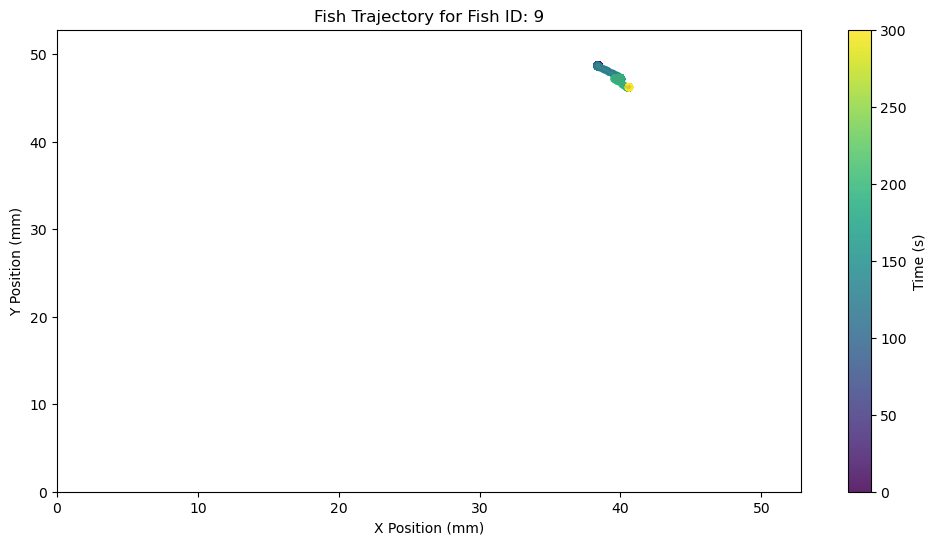

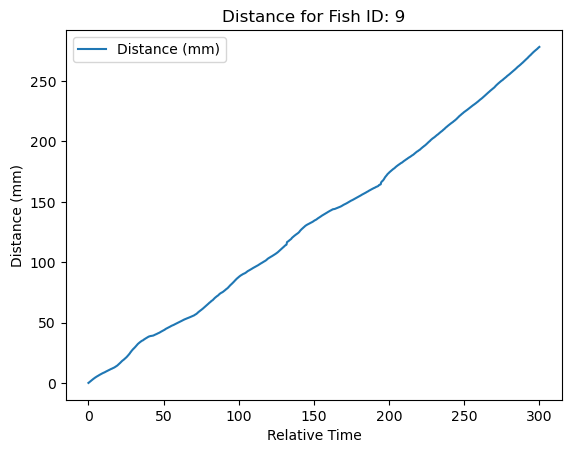

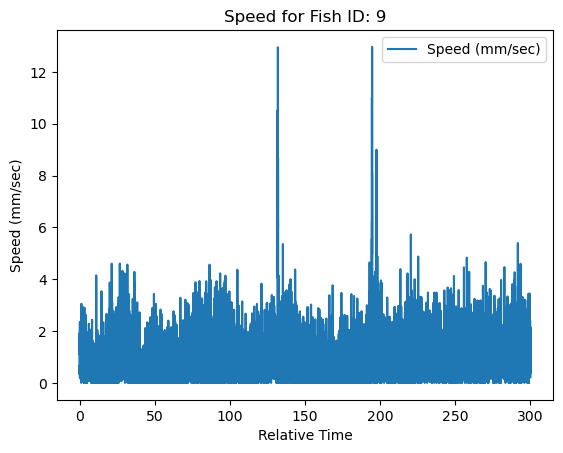

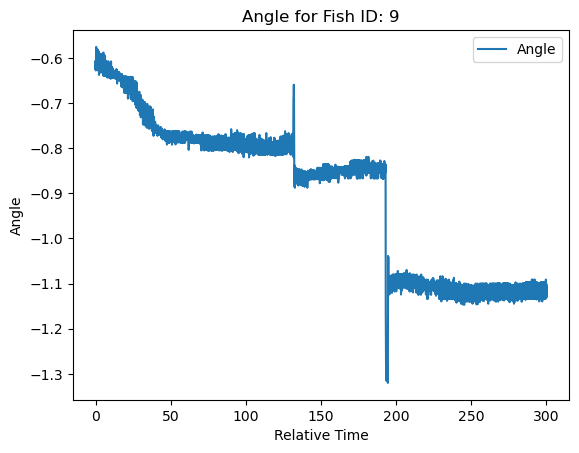

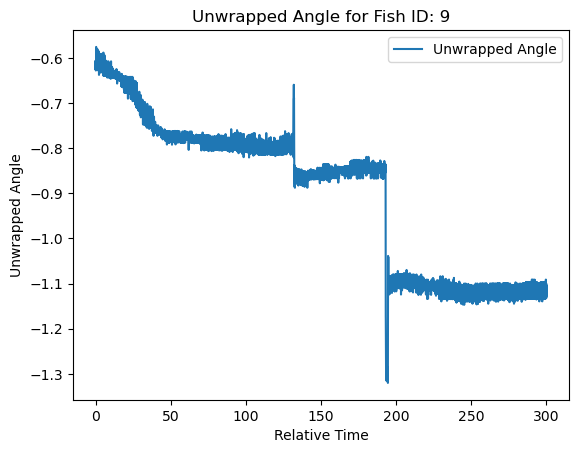

In [10]:
# Load the data
dark_df = pd.read_csv(r'.\dark_data.csv')
grouped_df = dark_df.groupby('fish_id')
for fish_id, group in grouped_df:
            group['relative_time'] = get_relative_time(group)
            group['relative_index'] = get_relative_index(group)
            group['distance'] = get_cumulative_distance(group)
            group['angle'], group['unwrapped_angle'] = get_heading_angle(group)
            group['speed'] = get_cumulative_speed(group)
            group['displacement_speed'] = get_displacement_speed(group)
            
            # Plotting
            custom_cmap = plt.cm.get_cmap('viridis')
            
            # Trajectory plot
            plt.figure(figsize=(12, 6))
            plt.scatter(
                group['centroid_x'] / PIX_PER_MM, 
                group['centroid_y'] / PIX_PER_MM, 
                c=group['relative_time'], 
                cmap=custom_cmap, 
                s=20, 
                alpha=0.85
            )
            plt.colorbar(label='Time (s)')
            plt.title(f'Fish Trajectory for Fish ID: {fish_id}')
            plt.xlabel('X Position (mm)')
            plt.ylabel('Y Position (mm)')
            plt.plot(
                group['centroid_x'] / PIX_PER_MM, 
                group['centroid_y'] / PIX_PER_MM, 
                color='gray', 
                linewidth=1.5, 
                alpha=0.3
            )
            plt.xlim(0, CAM_WIDTH / PIX_PER_MM)
            plt.ylim(0, CAM_HEIGHT / PIX_PER_MM)
            plt.show()
            
            # Distance plot
            plt.figure()
            plt.plot(group['relative_time'], group['distance'], label='Distance (mm)')
            plt.title(f'Distance for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Distance (mm)')
            plt.legend()
            plt.show()
            
            # Speed plot
            plt.figure()
            plt.plot(group['relative_time'], group['speed'], label='Speed (mm/sec)')
            plt.title(f'Speed for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Speed (mm/sec)')
            plt.legend()
            plt.show()
            
            # Angle plot
            plt.figure()
            plt.plot(group['relative_time'], group['angle'], label='Angle')
            plt.title(f'Angle for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Angle')
            plt.legend()
            plt.show()
            
            # Unwrapped angle plot
            plt.figure()
            plt.plot(group['relative_time'], group['unwrapped_angle'], label='Unwrapped Angle')
            plt.title(f'Unwrapped Angle for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Unwrapped Angle')
            plt.legend()
            plt.show()

In [10]:
dark_df[dark_df['fish_id']==9].head(n=100)

,t_display,t_local,latency,centroid_x,centroid_y,pc1_x,pc1_y,pc2_x,pc2_y,left_eye_x,...,fish_id,dpf,date,relative_time,relative_index,distance_mm,displacement,angle,unwrapped_angle,speed_mm_per_sec
18006,15898514654384,300.047361,20.022448,38.447688,48.720027,0.811639,-0.584159,0.584159,0.811639,17.989422,...,9,9,2024-08-27 16:03:14,0.004607,18006,241.112198,4.417740,-0.623844,-0.623844,-0.803486
18007,15898527424754,300.060131,16.015602,38.447021,48.728062,0.815661,-0.578530,0.578530,0.815661,17.391008,...,9,9,2024-08-27 16:03:14,0.017378,18007,241.120260,4.417780,-0.616926,-0.616926,18881.227441
18008,15898544087643,300.076794,15.901275,38.449168,48.721507,0.819271,-0.573407,0.573407,0.819271,17.575836,...,9,9,2024-08-27 16:03:14,0.034041,18008,241.127158,4.419343,-0.610658,-0.610658,14470.909450
18009,15898568753335,300.101460,23.789751,38.462479,48.731436,0.821986,-0.569508,0.569508,0.821986,16.875126,...,9,9,2024-08-27 16:03:14,0.058706,18009,241.143764,4.433476,-0.605907,-0.605907,9776.484863
18010,15898581770480,300.114477,20.029680,38.462681,48.727237,0.810957,-0.585105,0.585105,0.810957,18.013859,...,9,9,2024-08-27 16:03:14,0.071724,18010,241.147969,4.433305,-0.625010,-0.625010,18525.411610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18101,15900099652054,301.632359,21.670358,38.466858,48.719064,0.819212,-0.573491,0.573491,0.819212,17.374683,...,9,9,2024-08-27 16:03:14,1.589605,18101,242.779063,4.436755,-0.610761,-0.610761,14868.384970
18102,15900116778772,301.649485,23.068436,38.453469,48.741983,0.822590,-0.568635,0.568635,0.822590,16.502171,...,9,9,2024-08-27 16:03:14,1.606732,18102,242.805607,4.425455,-0.604845,-0.604845,14177.007371
18103,15900133177865,301.665884,21.641737,38.452162,48.717099,0.815906,-0.578185,0.578185,0.815906,17.583286,...,9,9,2024-08-27 16:03:14,1.623131,18103,242.830526,4.421944,-0.616502,-0.616502,14807.558295
18104,15900150087900,301.682794,21.774556,38.448523,48.734808,0.819710,-0.572779,0.572779,0.819710,16.679401,...,9,9,2024-08-27 16:03:14,1.640041,18104,242.848605,4.419878,-0.609892,-0.609892,14361.212425


C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_11436\2536609852.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


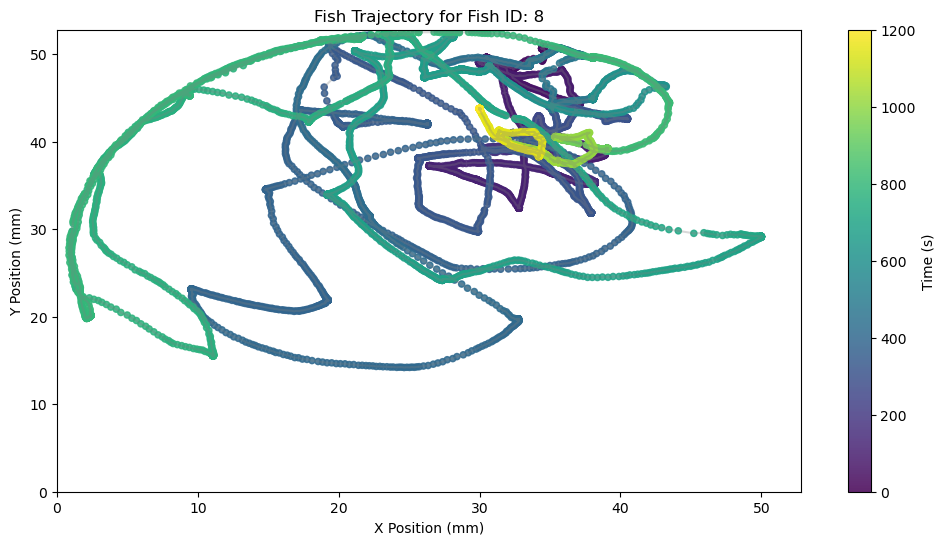

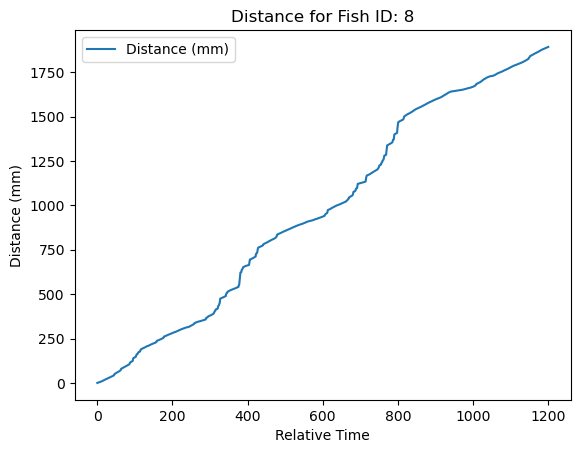

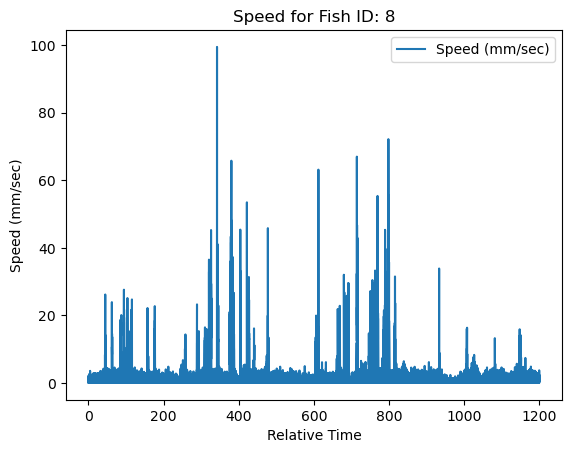

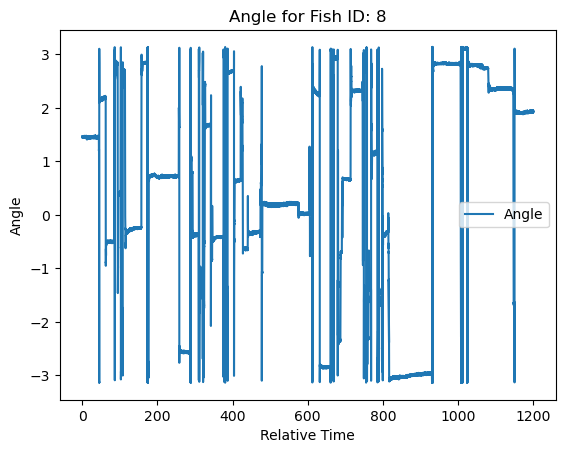

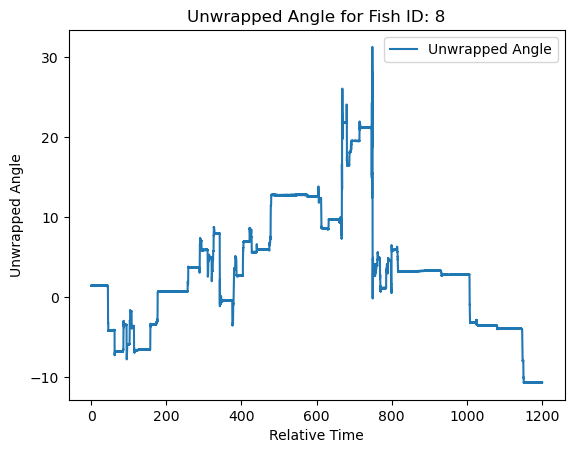

C:\Users\sai.ayachit\AppData\Local\Temp\ipykernel_11436\2536609852.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  custom_cmap = plt.cm.get_cmap('viridis')


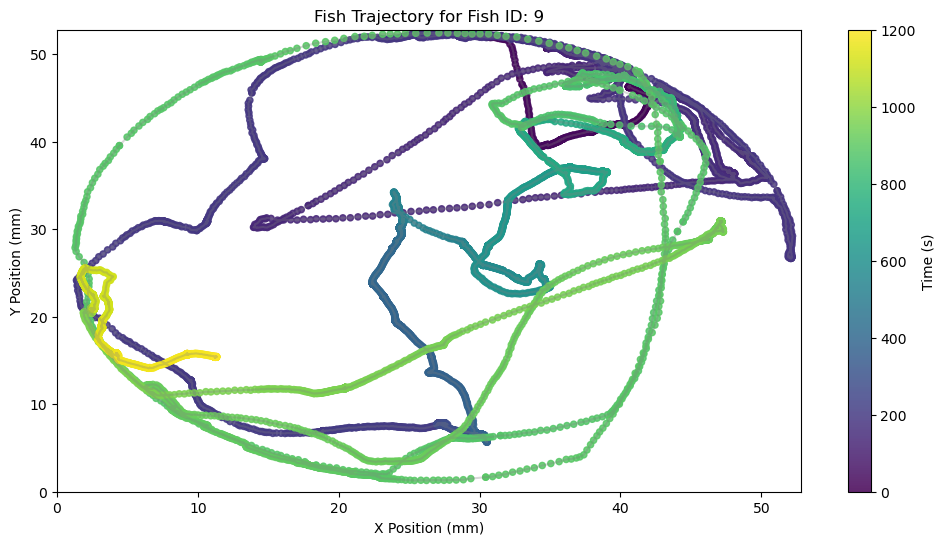

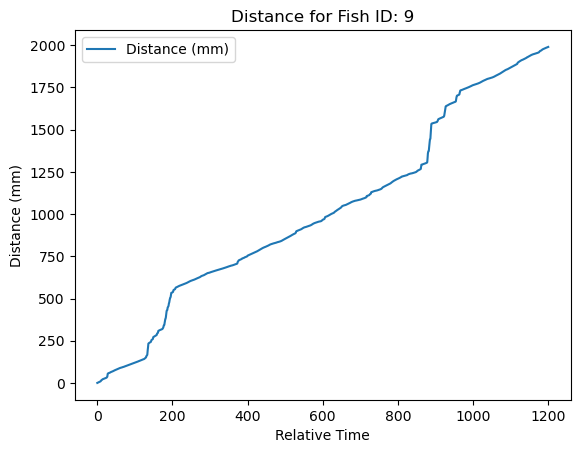

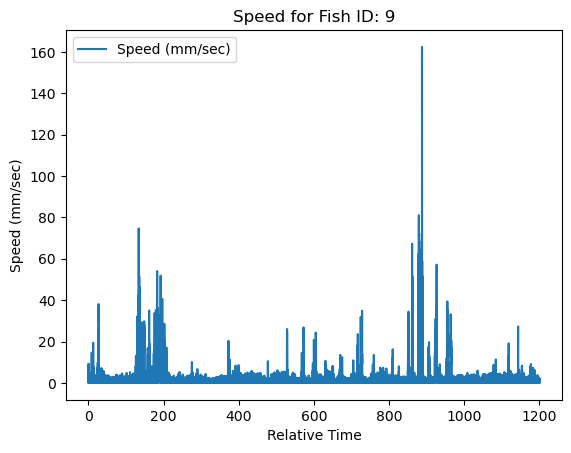

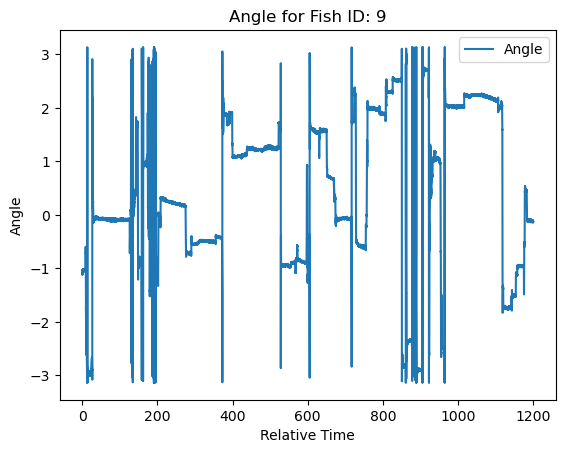

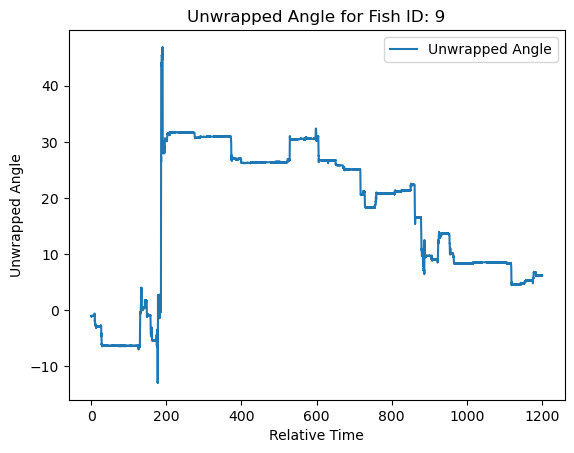

In [11]:
# Load the data
phototaxis_df = pd.read_csv(r'.\phototaxis_data.csv')
grouped_df = phototaxis_df.groupby('fish_id')
for fish_id, group in grouped_df:
            group['relative_time'] = get_relative_time(group)
            group['relative_index'] = get_relative_index(group)
            group['distance'] = get_cumulative_distance(group)
            group['angle'], group['unwrapped_angle'] = get_heading_angle(group)
            group['speed'] = get_cumulative_speed(group)
            group['displacement_speed'] = get_displacement_speed(group)
            
            # Plotting
            custom_cmap = plt.cm.get_cmap('viridis')
            
            # Trajectory plot
            plt.figure(figsize=(12, 6))
            plt.scatter(
                group['centroid_x'] / PIX_PER_MM, 
                group['centroid_y'] / PIX_PER_MM, 
                c=group['relative_time'], 
                cmap=custom_cmap, 
                s=20, 
                alpha=0.85
            )
            plt.colorbar(label='Time (s)')
            plt.title(f'Fish Trajectory for Fish ID: {fish_id}')
            plt.xlabel('X Position (mm)')
            plt.ylabel('Y Position (mm)')
            plt.plot(
                group['centroid_x'] / PIX_PER_MM, 
                group['centroid_y'] / PIX_PER_MM, 
                color='gray', 
                linewidth=1.5, 
                alpha=0.3
            )
            plt.xlim(0, CAM_WIDTH / PIX_PER_MM)
            plt.ylim(0, CAM_HEIGHT / PIX_PER_MM)
            plt.show()
            
            # Distance plot
            plt.figure()
            plt.plot(group['relative_time'], group['distance'], label='Distance (mm)')
            plt.title(f'Distance for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Distance (mm)')
            plt.legend()
            plt.show()
            
            # Speed plot
            plt.figure()
            plt.plot(group['relative_time'], group['speed'], label='Speed (mm/sec)')
            plt.title(f'Speed for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Speed (mm/sec)')
            plt.legend()
            plt.show()
            
            # Angle plot
            plt.figure()
            plt.plot(group['relative_time'], group['angle'], label='Angle')
            plt.title(f'Angle for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Angle')
            plt.legend()
            plt.show()
            
            # Unwrapped angle plot
            plt.figure()
            plt.plot(group['relative_time'], group['unwrapped_angle'], label='Unwrapped Angle')
            plt.title(f'Unwrapped Angle for Fish ID: {fish_id}')
            plt.xlabel('Relative Time')
            plt.ylabel('Unwrapped Angle')
            plt.legend()
            plt.show()

In [7]:




def analyse_phototaxis(data, fish_id, dpf):
    phototaxis = data[data['stim_id'] == StimType.PHOTOTAXIS]

    def get_data(polarity):
        pol = phototaxis[phototaxis['phototaxis_polarity'] == polarity]
        time = get_relative_time(pol)
        angle, angle_unwrapped = get_heading_angle(pol)
        res = pd.DataFrame({
            'time': time, 
            'angle': angle, 
            'angle_unwrapped': angle_unwrapped,
            'polarity': polarity,
            'fish_id': fish_id,
            'dpf': dpf
        })
        res = res.set_index(get_relative_index(pol))
        return res

    res = pd.concat((get_data(1),get_data(-1)))
    return res



def plot_heading_angle(data):
    angle, angle_unwrapped = get_heading_angle(data)
    distance = get_distance(data)

    plt.figure()
    ax1 = plt.subplot(311)
    ax1.plot(
        data['t_local'], 
        angle
    )
    ax2 = plt.subplot(312, sharex=ax1)
    ax2.plot(
        data['t_local'], 
        angle_unwrapped
    )
    ax2.set_ylabel('cum. angle')
    ax3 = plt.subplot(313, sharex=ax1)
    ax3.plot(
        data['t_local'], 
        distance
    )
    ax3.set_ylabel('distance')
    plt.show()

In [8]:
DATA_FOLDER = r".\Modelling_data\Cichlids"

DATAFILES = [
    "08_09dpf_Di_27_Aug_2024_14h50min47sec.csv", 
    "09_09dpf_Di_27_Aug_2024_16h03min14sec.csv"
]

phototaxis = pd.DataFrame()

for file in DATAFILES:
    print(file)
    fish_id, dpf, date = parse_filename(file)
    data = pd.read_csv(os.path.join(DATA_FOLDER,file))
    data_filtered = data.groupby('image_index').first()
    data_filtered = data_filtered[1:]
    data_filtered['stim_id'] = data_filtered['stim_id'].astype(int)
    #phototaxis = data_filtered[['t_display', 't_local', 'latency', 'centroid_x', 'centroid_y', 'pc1_x',
     #  'pc1_y', 'pc2_x', 'pc2_y',]] 
    phototaxis = pd.concat((
        phototaxis, 
        analyse_phototaxis(data_filtered, fish_id, dpf)
    ))

    ## save 
phototaxis.to_csv('phototaxis.csv')

## load
phototaxis = pd.read_csv('phototaxis.csv')
print(phototaxis.head)

08_09dpf_Di_27_Aug_2024_14h50min47sec.csv
09_09dpf_Di_27_Aug_2024_16h03min14sec.csv
<bound method NDFrame.head of         image_index        time     angle  angle_unwrapped  polarity  fish_id  \
0                 0    0.000000  0.025864         0.025864         1        8   
1                 1    0.016780  0.025864         0.025864         1        8   
2                 2    0.037573  0.034523         0.034523         1        8   
3                 3    0.050093  0.018354         0.018354         1        8   
4                 4    0.066864  0.011306         0.011306         1        8   
...             ...         ...       ...              ...       ...      ...   
144008        36000  600.003596 -1.213488        30.202439        -1        9   
144009        36001  600.020272 -1.244798        30.171129        -1        9   
144010        36002  600.036948 -1.222917        30.193010        -1        9   
144011        36003  600.053653 -1.178235        30.237691        -1        

In [9]:
print(phototaxis.columns)

Index(['image_index', 'time', 'angle', 'angle_unwrapped', 'polarity',
       'fish_id', 'dpf'],
      dtype='object')


In [10]:
print(phototaxis.columns)

Index(['image_index', 'time', 'angle', 'angle_unwrapped', 'polarity',
       'fish_id', 'dpf'],
      dtype='object')


In [11]:
phototaxis.shape

(144013, 7)

In [12]:
phototaxis.shape

(144013, 7)

In [13]:
phototaxis.isnull().any()

image_index        False
time               False
angle              False
angle_unwrapped    False
polarity           False
fish_id            False
dpf                False
dtype: bool

In [14]:
data_filtered.isnull().sum()

t_display                             0
t_local                               0
latency                               0
centroid_x                            0
centroid_y                            0
                                     ..
looming_center_mm_x                   0
looming_center_mm_y                   0
looming_period_sec                    0
looming_expansion_time_sec            0
looming_expansion_speed_mm_per_sec    0
Length: 107, dtype: int64

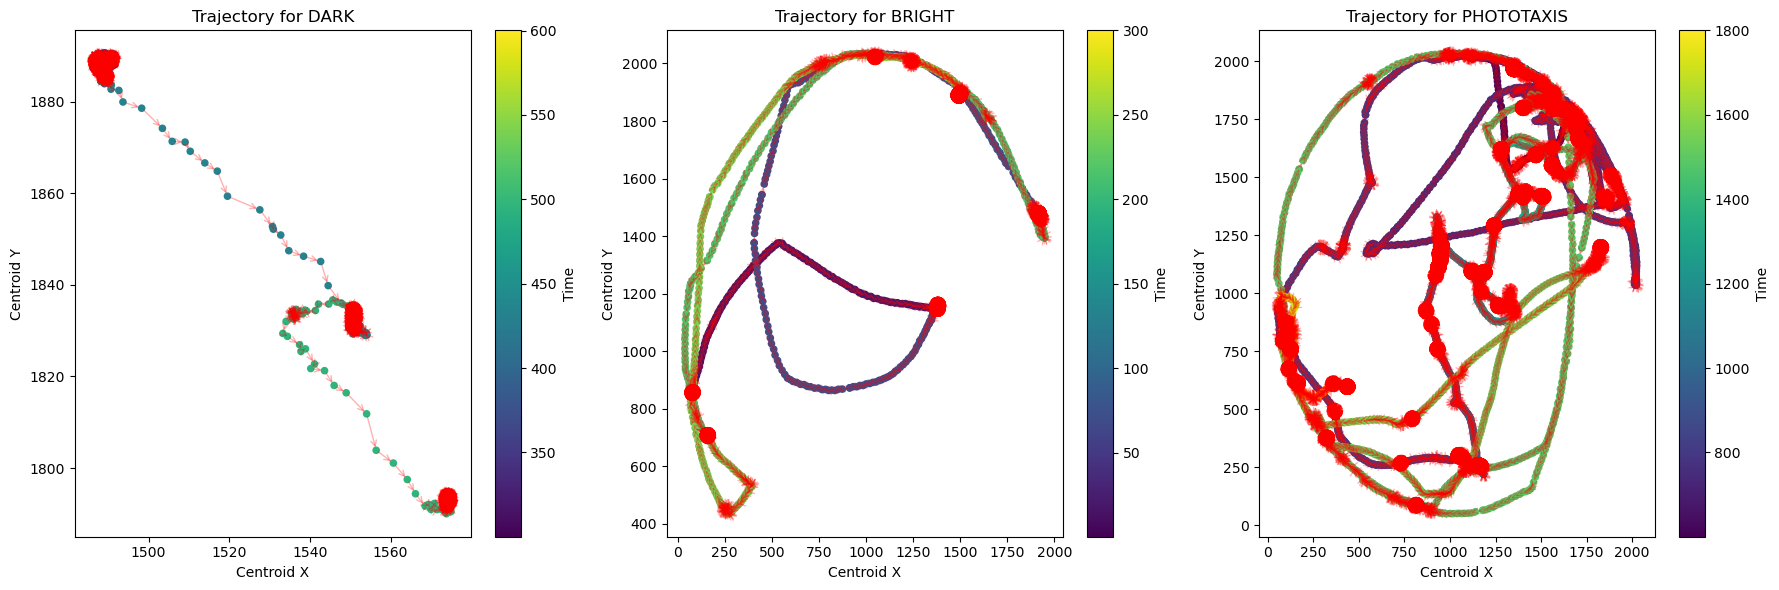

In [ ]:
def plot_fish_trajectories(data):
    # Create a figure with subplots for each stimulus type
    stim_types = [StimType.DARK, StimType.phototaxis, StimType.PHOTOTAXIS]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, stim_type in enumerate(stim_types):
        # Filter data for specific stimulus type
        stim_data = data[data['stim_id'] == stim_type]
        
        # Create scatter plot with color gradient based on time
        scatter = axes[i].scatter(
            stim_data['centroid_x'], 
            stim_data['centroid_y'],
            c=stim_data['t_local'],  # Color based on time
            cmap='viridis',       # Color gradient
            s=20                  # Point size
        )
        
        # Add colorbar
        plt.colorbar(scatter, ax=axes[i], label='Time')
        
        # Set labels and title
        axes[i].set_title(f'Trajectory for {stim_type.name}')
        axes[i].set_xlabel('Centroid X')
        axes[i].set_ylabel('Centroid Y')
        
        # Optional: add arrows to show direction
        for j in range(len(stim_data)-1):
            axes[i].annotate('', 
                xy=(stim_data['centroid_x'].iloc[j+1], stim_data['centroid_y'].iloc[j+1]),
                xytext=(stim_data['centroid_x'].iloc[j], stim_data['centroid_y'].iloc[j]),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.3)
            )
    
    plt.tight_layout()
    plt.show()

# Assuming 'data' is your preprocessed DataFrame
plot_fish_trajectories(data_filtered)

In [ ]:
# def smooth_data_with_nans(speed_data, method='gaussian', **kwargs):
#     """
#     Apply smoothing to speed data that may contain NaN values
    
#     Parameters:
#     - speed_data: Series or array with speed values
#     - method: Smoothing method ('gaussian', 'moving_avg', or 'ewm')
#     - kwargs: Additional parameters for the chosen method
    
#     Returns:
#     - Smoothed data array
#     """
#     # Convert to pandas Series if not already
#     data = pd.Series(speed_data)
    
#     # First, get the indices of non-NaN values
#     valid_indices = ~data.isna()
    
#     if method == 'gaussian':
#         # Default parameters
#         sigma = kwargs.get('sigma', 2)
        
#         # Create a copy to avoid modifying the original
#         smoothed = data.copy()
        
#         # Apply Gaussian filter only to non-NaN values
#         if valid_indices.any():
#             # Fill NaNs temporarily with 0 for filtering
#             temp_data = data.fillna(0)
            
#             # Create a mask of valid values (1 for valid, 0 for NaN)
#             mask = valid_indices.astype(float)
            
#             # Apply Gaussian filter to data and mask
#             smoothed_data = gaussian_filter1d(temp_data.values, sigma=sigma)
#             smoothed_mask = gaussian_filter1d(mask.values, sigma=sigma)
            
#             # Divide filtered data by filtered mask where mask is not 0
#             with np.errstate(divide='ignore', invalid='ignore'):
#                 result = np.where(smoothed_mask > 1e-10, 
#                                  smoothed_data / smoothed_mask, 
#                                  np.nan)
            
#             # Update only previously valid points
#             smoothed.loc[valid_indices] = result[valid_indices]
        
#     elif method == 'moving_avg':
#         # Default parameters
#         window = kwargs.get('window', 15)
#         min_periods = kwargs.get('min_periods', 1)
        
#         # Apply rolling window average
#         smoothed = data.rolling(
#             window=window, 
#             center=True, 
#             min_periods=min_periods
#         ).mean()
        
#     elif method == 'ewm':
#         # Default parameters
#         span = kwargs.get('span', 10)
#         min_periods = kwargs.get('min_periods', 1)
        
#         # Apply exponentially weighted moving average
#         smoothed = data.ewm(
#             span=span, 
#             min_periods=min_periods
#         ).mean()
    
#     else:
#         raise ValueError(f"Unknown smoothing method: {method}")
        
#     return smoothed

# def detect_fish_bouts(data, fish_id=None):
#     """
#     Process fish movement data to detect swimming bouts
    
#     Parameters:
#     - data: DataFrame containing fish movement data
#     - fish_id: Optional ID for the fish (for plot titles)
    
#     Returns:
#     - Dictionary containing processed data and bout information
#     """
#     # Make a copy to avoid modifying the original data
#     df = data.reset_index(drop=True).copy()
    
#     smoothed_speed = smooth_data_with_nans(df['speed'], method='gaussian', sigma=2)
#     df['smoothed_speed'] = smoothed_speed
    
#     # Calculate threshold for bout detection
#     mean_speed = np.mean(smoothed_speed)
#     std_speed = np.std(smoothed_speed)
#     threshold = mean_speed + 2 * std_speed
    
#     # Find peaks in the smoothed data (potential bout centers)
#     peaks, peak_properties = find_peaks(
#         smoothed_speed, 
#         height=threshold,
#         distance=10,  # Minimum samples between peaks
#         prominence=0.5 * std_speed  # Minimum prominence to be considered a peak
#     )
    
#     # Find regions where speed exceeds threshold (bout regions)
#     bout_indices = np.where(smoothed_speed > threshold)[0]
    
#     # Group consecutive indices to identify complete bouts
#     bout_groups = []
#     for k, g in groupby(enumerate(bout_indices), lambda x: x[0] - x[1]):
#         group = list(map(itemgetter(1), g))
#         if len(group) > 3:  # Minimum number of frames to be considered a bout
#             bout_groups.append((group[0], group[-1]))
    
#     # Create a DataFrame to store bout information
#     bout_info = []
#     for i, (start_idx, end_idx) in enumerate(bout_groups):
#         # Find the peak within this bout
#         bout_peaks = [p for p in peaks if start_idx <= p <= end_idx]
        
#         if bout_peaks:
#             peak_idx = bout_peaks[np.argmax(smoothed_speed[bout_peaks])]
#             peak_speed = smoothed_speed[peak_idx]
            
#             # Calculate bout properties
#             bout_info.append({
#                 'bout_id': i+1,
#                 'start_idx': start_idx,
#                 'peak_idx': peak_idx,
#                 'end_idx': end_idx,
#                 'start_time': df['relative_time'].iloc[start_idx],
#                 'peak_time': df['relative_time'].iloc[peak_idx],
#                 'end_time': df['relative_time'].iloc[end_idx],
#                 'duration': df['relative_time'].iloc[end_idx] - df['relative_time'].iloc[start_idx],
#                 'peak_speed': peak_speed,
#                 'mean_speed': np.mean(smoothed_speed[start_idx:end_idx+1])
#             })
    
#     bout_df = pd.DataFrame(bout_info)
    
#     return {
#         'processed_data': df,
#         'smoothed_speed': smoothed_speed,
#         'threshold': threshold,
#         'peaks': peaks,
#         'bout_groups': bout_groups,
#         'bout_df': bout_df,
#         'fish_id': fish_id
#     }

# def plot_bout_detection(results):
#     """
#     Create plots to visualize the bout detection process
    
#     Parameters:
#     - results: Dictionary returned by detect_fish_bouts function
#     """
#     df = results['processed_data']
#     fish_id = results['fish_id']
#     smoothed_speed = results['smoothed_speed']
#     threshold = results['threshold']
#     peaks = results['peaks']
#     bout_groups = results['bout_groups']
    
#     # Create figure with 2 subplots
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
#     # Plot 1: Original vs Smoothed Speed
#     ax1.plot(df['relative_time'], df['speed'], 'b-', alpha=0.5, label='Raw Speed')
#     ax1.plot(df['relative_time'], smoothed_speed, 'g-', linewidth=2, label='Smoothed Speed')
#     ax1.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
#     ax1.set_ylabel('Speed (mm/sec)')
#     ax1.set_title(f'Original vs Smoothed Speed for Fish ID: {fish_id}')
#     ax1.legend()
#     ax1.grid(alpha=0.3)
    
#     # Plot 2: Detected Bouts
#     ax2.plot(df['relative_time'], smoothed_speed, 'g-', label='Smoothed Speed')
#     ax2.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({threshold:.2f})')
    
#     # Highlight bout regions
#     for start_idx, end_idx in bout_groups:
#         start_time = df['relative_time'].iloc[start_idx]
#         end_time = df['relative_time'].iloc[end_idx]
#         ax2.axvspan(start_time, end_time, alpha=0.2, color='orange')
    
#     # Mark peak points
#     peak_times = df['relative_time'].iloc[peaks]
#     peak_speeds = smoothed_speed[peaks]
#     ax2.scatter(peak_times, peak_speeds, color='red', s=50, zorder=5, label='Bout Peaks')
    
#     ax2.set_xlabel('Relative Time')
#     ax2.set_ylabel('Speed (mm/sec)')
#     ax2.set_title(f'Detected Swimming Bouts for Fish ID: {fish_id}')
#     ax2.legend()
#     ax2.grid(alpha=0.3)
    
#     plt.tight_layout()
#     return fig

# def print_bout_statistics(results):
#     """
#     Print statistics about the detected bouts
    
#     Parameters:
#     - results: Dictionary returned by detect_fish_bouts function
#     """
#     bout_df = results['bout_df']
#     fish_id = results['fish_id']
    
#     print(f"\nBout Statistics for Fish ID: {fish_id}")
#     print(f"Total number of bouts detected: {len(bout_df)}")
    
#     if len(bout_df) > 0:
#         print(f"Average bout duration: {bout_df['duration'].mean():.2f} time units")
#         print(f"Average bout peak speed: {bout_df['peak_speed'].mean():.2f} mm/sec")
#         print(f"Average bout mean speed: {bout_df['mean_speed'].mean():.2f} mm/sec")
#         print("\nTop 5 bouts by peak speed:")
#         print(bout_df.sort_values('peak_speed', ascending=False).head(5)[['bout_id', 'start_time', 'duration', 'peak_speed']])